In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/ColabTemp"

In [2]:
# !wget "https://raw.githubusercontent.com/Ali-Ai-Dev/federated-learning-test/main/cca_core.py"

In [3]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader
from torch import nn
from collections import OrderedDict
import matplotlib.pyplot as plt
import cca_core, cka_core_torch
import random
import copy
import os
import glob
import time
import numpy as np
import argparse
import shutil

In [4]:
# Set seed for reproducing code
mySeed = 42
random.seed(mySeed)  # Python random module.
np.random.seed(mySeed)  # Numpy module.
torch.manual_seed(mySeed)
torch.cuda.manual_seed(mySeed)
torch.cuda.manual_seed_all(mySeed)  # if you are using multi-GPU.

dataloader_generator = torch.Generator()
dataloader_generator.manual_seed(mySeed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
def float_range(mini, maxi):
    """Return function handle of an argument type function for 
       ArgumentParser checking a float range: mini <= arg <= maxi
         mini - minimum acceptable argument
         maxi - maximum acceptable argument"""

    # Define the function with default arguments
    def float_range_checker(arg):
        """New Type function for argparse - a float within predefined range."""

        try:
            f = float(arg)
        except ValueError:    
            raise argparse.ArgumentTypeError("must be a floating point number")
        if f < mini or f > maxi:
            raise argparse.ArgumentTypeError("must be in range [" + str(mini) + " .. " + str(maxi)+"]")
        return f

    # Return function handle to checking function
    return float_range_checker

In [6]:
# # Hyper parameters (Auto)
# parser = argparse.ArgumentParser(prog='FedSwap_Similarity',
#                                  description="FedSwap_Similarity: Converging Federated Learning Faster",
#                                  epilog="Written by Ali Bozorgzad")

# parser.add_argument("--dataset", "-d", dest="dataset_name", type=str, default="CIFAR10",
#                     help="dataset name", choices=['MNIST', 'CIFAR10', 'CINIC10', 'FEMNIST'])
# parser.add_argument("--NN_type", "-n", dest="neural_network_type", type=str, default="Conv",
#                     help="neural network type", choices=['MLP', 'Conv'])
# parser.add_argument("--similarity_mode", "-m", dest="similarity_mode", type=str, default="cka_rbf",
#                     help="similarity mode", choices=['cca', 'cka_linear', 'cka_rbf'])
# parser.add_argument("--swap_mode", "-o", dest="swap_mode", type=str, default="best",
#                     help="swap mode", choices=['greedy', 'best'])
# parser.add_argument("--num_clients", "-c", dest="num_clients", type=int, default="10",
#                     help="number of clients")
# parser.add_argument("--batch_size", "-b", dest="batch_size", type=int, default="64",
#                     help="batch size")
# parser.add_argument("--total_steps", "-t", dest="total_steps", type=int, default="301",
#                     help="total steps")
# parser.add_argument("--client_per", "-p", dest="client_select_percentage", type=float_range(1e-2, 1), default="1",
#                     help="client selection percentage, between [1e-2...1] 1 is 100%%")
# parser.add_argument("--random_split", "-r", dest="data_random_split", type=int, default="1",
#                     help="data random split between clients", choices=[0, 1])
# parser.add_argument("--learning_rate", "-l", dest="learning_rate", type=float, default="1e-3",
#                     help="learning rate")
# parser.add_argument("--client_epochs", "-e", dest="client_epochs", type=int, default="1",
#                     help="client epochs")
# parser.add_argument("--swap_step", "-s", dest="swap_step", type=int, default="3",
#                     help="swap clients weights after X step")
# parser.add_argument("--num_swap_bet_avg", "-a", dest="n_swap_bet_avg_p1", type=int, default="10",
#                     help="number of swap between avg, plus one to your number= if need 2 swap between avg, enter 3")
# parser.add_argument("--remain", dest="remain", type=float_range(1e-3, 1), default="1",
#                     help="remain %% of dataset for running faster in test, between [1e-3...1] 1 is 100%%")

# args, unknown = parser.parse_known_args()


# dataset_name = args.dataset_name
# neural_network_type = args.neural_network_type
# similarity_mode = args.similarity_mode
# swap_mode = args.swap_mode

# num_clients = args.num_clients
# batch_size = args.batch_size
# total_steps = args.total_steps
# client_select_percentage = args.client_select_percentage
# data_random_split = args.data_random_split

# learning_rate = args.learning_rate
# loss_fn = nn.CrossEntropyLoss()
# client_epochs = args.client_epochs

# swap_step = args.swap_step
# n_swap_bet_avg_p1 = args.n_swap_bet_avg_p1

# remain = args.remain

In [7]:
# Hyper parameters (Manual)
dataset_name = "FEMNIST" # 'MNIST' or 'CIFAR10' or 'CINIC10' or 'FEMNIST'
neural_network_type = "Conv" # 'MLP' or 'Conv'
similarity_mode = "cka_rbf" # 'cca' or 'cka_linear' or 'cka_rbf'
swap_mode = "best" # 'greedy' or 'best'

num_clients = 10
batch_size = 64
total_steps = 301
client_select_percentage = 1
data_random_split = 1 # 0 or 1

learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
client_epochs = 1

swap_step = 3
n_swap_bet_avg_p1 = 10 # p1=plus one to your number, if need 2 swap between avg, enter 3

remain = 0.001 # Remove some data for running faster in test

In [8]:
# Initialize parameters
client_selects = None
client_weights = None

passed_steps = 0
is_print_eval = False

start_bold = "\u001b[1m"
end_bold = "\033[0m"
os.system("color")
color = {
    "ENDC": end_bold,
    "Bold": start_bold,
}

os.makedirs("datasets", exist_ok=True)
os.makedirs("save_log", exist_ok=True)

if dataset_name == 'CINIC10' or dataset_name == 'FEMNIST':
    neural_network_classname = f"Neural_Network_CIFAR10_{neural_network_type}"
else:
    neural_network_classname = f"Neural_Network_{dataset_name}_{neural_network_type}"

save_file_name_pre = f"""FSS
_{dataset_name}_{neural_network_type}_{similarity_mode}_{swap_mode}
_{num_clients}c_{batch_size}b_{total_steps}s_{client_select_percentage}cp_{data_random_split}rs
_{learning_rate}lr_{client_epochs}ce_{swap_step}_{n_swap_bet_avg_p1}_step"""
save_file_name_pre = save_file_name_pre.replace("\n", "")

In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using '{device}' device")

Using 'cuda' device


## Load Data

In [10]:
def download_femnist_dataset_ready_to_read():
    ### ToDo: Download and extract dataset to datasets dir
    cur_dir = os.getcwd()
    datasets_dir = os.path.join(cur_dir, "datasets")

    if os.path.isdir(os.path.join(datasets_dir, "by_class")):
        dataset_dir = os.path.join(datasets_dir, "FEMNIST")
        os.rename(os.path.join(datasets_dir, "by_class"), dataset_dir)

        for i, class_dir in enumerate(os.listdir(dataset_dir)):
            class_imgs = os.path.join(dataset_dir, class_dir, "train_"+class_dir)
            shutil.move(class_imgs, dataset_dir)
            shutil.rmtree(os.path.join(dataset_dir, class_dir))
            print(f"Ready to be read and preprocess, class {i}.")


In [11]:
# Load dataset
if dataset_name == 'FEMNIST':
    download_femnist_dataset_ready_to_read()
    
    full_data = datasets.ImageFolder(
        'datasets/FEMNIST',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(32, 32)),
        ]),
        target_transform=Lambda(lambda y: torch.zeros(62).scatter_(dim=0, index=torch.tensor(y), value=1)),
    )

    lst_range = np.arange(0, len(full_data))
    lst_random = np.random.permutation(lst_range)
    test_indices = lst_random[: int(len(lst_random)*0.1)]
    train_indices = list(filter(lambda i: i not in test_indices, lst_range))

    train_data = torch.utils.data.Subset(full_data, train_indices)
    test_data = torch.utils.data.Subset(full_data, test_indices)

elif dataset_name == 'CINIC10':
    dataset_dir = 'datasets/CINIC-10'
    cinic_mean = [0.47889522, 0.47227842, 0.43047404]
    cinic_std = [0.24205776, 0.23828046, 0.25874835]
    
    train_data = datasets.ImageFolder(
        dataset_dir + '/train_valid',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=cinic_mean, std=cinic_std),
        ]),
        target_transform=Lambda(lambda y: torch.zeros(10).scatter_(dim=0, index=torch.tensor(y), value=1)),
    )

    test_data = datasets.ImageFolder(
        dataset_dir + '/test',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=cinic_mean, std=cinic_std),
        ]),
        target_transform=Lambda(lambda y: torch.zeros(10).scatter_(dim=0, index=torch.tensor(y), value=1)),
    )

else: # 'MNIST' or 'CIFAR10'
    running_dataset = getattr(datasets, dataset_name)

    train_data = running_dataset(
        root="datasets",
        train=True,
        download=True,
        transform=ToTensor(),
        target_transform=Lambda(lambda y: torch.zeros(10).scatter_(dim=0, index=torch.tensor(y), value=1)),    
    )

    test_data = running_dataset(
        root="datasets",
        train=False,
        download=True,
        transform=ToTensor(),
        target_transform=Lambda(lambda y: torch.zeros(10).scatter_(dim=0, index=torch.tensor(y), value=1)),
    )

print(len(train_data))
print(train_data[0][0].shape)
print(train_data[0][1])

658502
torch.Size([3, 32, 32])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [12]:
# Remove some data for running faster in test
print("remain data parameter:", remain)
print("full train_data size:", len(train_data))
train_data = torch.utils.data.Subset(train_data, range(0, int(len(train_data)*remain)))
print("cutted train_data size:", len(train_data))

print("full test_data size:", len(test_data))
test_data = torch.utils.data.Subset(test_data, range(0, int(len(test_data)*remain)))
print("cutted test_data size:", len(test_data))

remain data parameter: 0.001
full train_data size: 658502
cutted train_data size: 658
full test_data size: 73166
cutted test_data size: 73


In [10]:
# Split data to each client
client_data_size = np.array([len(train_data)//num_clients]*num_clients)
data_remain = len(train_data) % num_clients
for i in range(data_remain):
    client_data_size[-1-i] += 1

if data_random_split:
    client_datasets = torch.utils.data.random_split(train_data, client_data_size)
else:
    client_datasets = list()
    i = 0
    for j in client_data_size:
        client_datasets.append(torch.utils.data.Subset(train_data, range(i, i+j)))
        i += j

In [11]:
# Create dataloader for each client
client_dataloaders = np.zeros(num_clients, dtype=object)
for i, dataset in enumerate(client_datasets):
    client_dataloaders[i] = DataLoader(dataset=dataset, batch_size=batch_size,
                                       shuffle=True, generator=dataloader_generator,)

test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size,
                             shuffle=True, generator=dataloader_generator,)

## Training

In [12]:
def calc_out_conv_max_layers(in_w, in_h, kernels, strides, paddings=None, dilations=None):
    # In MaxPool2d, strides must same with kernels
    if paddings == None:
        paddings = np.zeros(len(kernels))
    
    if dilations == None:
        dilations = np.ones(len(kernels))
    
    out_w = in_w
    out_h = in_h
    for ker, pad, dil, stri in zip(kernels, paddings, dilations, strides):
        out_w = np.floor((out_w + 2*pad - dil * (ker-1) - 1)/stri + 1)
        out_h = np.floor((out_h + 2*pad - dil * (ker-1) - 1)/stri + 1)

    return int(out_w), int(out_h)

In [13]:
# Define MLP models
input_flat_size = torch.flatten(train_data[0][0]).shape[0]
nClasses = train_data[0][1].shape[0]

class Neural_Network_MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(input_flat_size, 100)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(100, 99)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(99, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        probs = self.softmax(logits)
        return probs
    
    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data


class Neural_Network_CIFAR10_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(input_flat_size, 256)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(256, 128)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(128, 64)),
            ('relu3', nn.ReLU()),
            ('fc4', nn.Linear(64, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        probs = self.softmax(logits)
        return probs
    
    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data

In [14]:
# Define Convolutional models
input_channels, input_width, input_height = train_data[0][0].shape
conv_kernel = 3
max_kernel = 2

kernels = [conv_kernel, max_kernel, conv_kernel]
strides = [1, max_kernel, 1]
out_w1, out_h1 = calc_out_conv_max_layers(input_width, input_height, kernels, strides)

class Neural_Network_MNIST_Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.features_stack = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(input_channels, 32, kernel_size=conv_kernel, stride=1, padding=0)),
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=max_kernel)),
            ('conv2', nn.Conv2d(32, 64, kernel_size=conv_kernel)),
            ('relu2', nn.ReLU(inplace=True)),
            ('flat', nn.Flatten()),
            ('fc1', nn.Linear(64*out_w1*out_h1, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.features_stack(x)
        probs = self.softmax(logits)
        return probs

    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data


kernels = [conv_kernel, max_kernel, conv_kernel, max_kernel]
strides = [1, max_kernel, 1, max_kernel]
out_w2, out_h2 = calc_out_conv_max_layers(input_width, input_height, kernels, strides)

class Neural_Network_CIFAR10_Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.features_stack = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(input_channels, 32, kernel_size=conv_kernel, stride=1, padding=0)),
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=max_kernel)),
            ('conv2', nn.Conv2d(32, 64, kernel_size=conv_kernel)),
            ('relu2', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool2d(kernel_size=max_kernel)),
            ('flat', nn.Flatten()),
            ('fc1', nn.Linear(64*out_w2*out_h2, 100)),
            ('relu3', nn.ReLU(inplace=True)),
            ('fc2', nn.Linear(100, nClasses)),
        ]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.features_stack(x)
        probs = self.softmax(logits)
        return probs

    def get_weights(self):
        return list(self.parameters())
    
    def set_weights(self, parameters_list):
        for i, param in enumerate(self.parameters()):
            param.data = parameters_list[i].data

In [15]:
def select_clients_and_assign_weights(global_weights):
    global client_selects
    global client_weights

    lst = np.arange(0, num_clients)
    np.random.shuffle(lst)
    client_selects = lst[: int(len(lst)*client_select_percentage)]

    client_weights = {i: copy.deepcopy(global_weights)  for i in client_selects}

In [16]:
# Create an instantiate of a class with string value!
global_model = globals()[neural_network_classname]().to(device)
global_weights = global_model.get_weights()
select_clients_and_assign_weights(global_weights)
print(global_model)

global_history = {"times": {"train":list(), "swap":list(), "step":list()},
                  "accuracy": list(),
                  "loss": list()}

# Load saved state & log
last_saved = sorted(glob.glob(f"save_log/{save_file_name_pre}_*.npz"), key=os.path.getmtime)
if last_saved:
    last_saved = last_saved[-1]
    passed_steps = int(last_saved.split("_")[-1].split(".")[0]) + 1

    npzFile = np.load(last_saved, allow_pickle=True)
    client_selects = npzFile["client_selects"]
    client_weights = npzFile["client_weights"].item()
    global_history = npzFile["global_history"].item()
    dataloader_generator_state = torch.tensor(npzFile["dataloader_generator_state"])
    random_state = tuple(npzFile["random_state_ndarray"])
    np_random_state = tuple(npzFile["np_random_state_ndarray"])
    # torch_rng_states = npzFile["torch_rng_states_ndarray"]
    npzFile.close()

    dataloader_generator.set_state(dataloader_generator_state)
    random.setstate(random_state)
    np.random.set_state(np_random_state)
    # torch.set_rng_state(torch_rng_states[0])
    # torch.cuda.set_rng_state(torch_rng_states[1])
    # torch.cuda.set_rng_state_all(torch_rng_states[2])

Neural_Network_MNIST_Conv(
  (features_stack): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU(inplace=True)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=7744, out_features=10, bias=True)
  )
  (softmax): Softmax(dim=1)
)


In [17]:
def scale_model_weights(weights, scalar):
    """ Scale the model weights """

    scaled_weights = list()
    for i in range(len(weights)):
        scaled_weights.append(weights[i] * scalar)

    return scaled_weights

In [18]:
def sum_scaled_weights(client_scaled_weights):
    """ Return the sum of the listed scaled weights.
        axis_O is equivalent to the average weight of the weights """

    avg_weights = list()
    # get the average gradient accross all client gradients
    for gradient_list_tuple in zip(*client_scaled_weights):
        gradient_list_tuple = [tensors.tolist()  for tensors in gradient_list_tuple]
        layer_mean = torch.sum(torch.tensor(gradient_list_tuple), axis=0).to(device)
        avg_weights.append(layer_mean)

    return avg_weights


### Explaining the function with example ###
# t = (torch.tensor([[[2, 3],[3, 4]], [[3, 4],[4, 5]], [[4, 5],[5, 6]]]),
#      torch.tensor([[[5, 6],[6, 7]], [[6, 7],[7, 8]], [[7, 8],[8, 9]]]))
# t = [i.tolist() for i in t]
# for y in zip(*t):
#     print(y)
#     print(torch.sum(torch.tensor(y), axis=0))

In [19]:
def fed_avg():
    # calculate total training data across clients
    global_count = 0
    for client in client_selects:
        global_count += len(client_dataloaders[client].dataset)

    # initial list to collect clients weight after scalling
    client_scaled_weights = list()
    for client in client_selects:
        local_count = len(client_dataloaders[client].dataset)
        scaling_factor = local_count / global_count
        scaled_weights = scale_model_weights(client_weights[client], scaling_factor)
        client_scaled_weights.append(scaled_weights)

    # to get the average over all the clients model, we simply take the sum of the scaled weights
    avg_weights = sum_scaled_weights(client_scaled_weights)

    return avg_weights

In [20]:
def fed_swap(client, swap_client):
    temp_weight = client_weights[swap_client]
    client_weights[swap_client] = client_weights[client]
    client_weights[client] = temp_weight

In [21]:
def model_similarity(weights_1, weights_2):
    lst_layer_similarity = list()
    for i in range(len(weights_1)):
        len_shape = len(weights_1[i].shape)

        if len_shape == 1: # bias weights
            continue

        # change it to two dimention
        if similarity_mode == "cca": # only CCA run in cpu
            weights_1_two_dim = weights_1[i].reshape(-1, weights_1[i].shape[-1]).cpu().detach().numpy()
            weights_2_two_dim = weights_2[i].reshape(-1, weights_2[i].shape[-1]).cpu().detach().numpy()
        else:
            weights_1_two_dim = weights_1[i].reshape(-1, weights_1[i].shape[-1])
            weights_2_two_dim = weights_2[i].reshape(-1, weights_2[i].shape[-1])

        if similarity_mode == "cka_rbf":
            gram_rbf_1 = cka_core_torch.gram_rbf(weights_1_two_dim, 0.5)
            gram_rbf_2 = cka_core_torch.gram_rbf(weights_2_two_dim, 0.5)
            layer_similarity = cka_core_torch.cka(gram_rbf_1, gram_rbf_2)
            
        elif similarity_mode == "cka_linear":
            gram_linear_1 = cka_core_torch.gram_linear(weights_1_two_dim)
            gram_linear_2 = cka_core_torch.gram_linear(weights_2_two_dim)
            layer_similarity = cka_core_torch.cka(gram_linear_1, gram_linear_2)

        elif similarity_mode == "cca":
            if weights_1_two_dim.shape[0] > weights_1_two_dim.shape[1]:
                weights_1_two_dim = weights_1_two_dim.T
                weights_2_two_dim = weights_2_two_dim.T

            # Mean Squared CCA similarity
            results = cca_core.get_cca_similarity(weights_1_two_dim, weights_2_two_dim, epsilon=1e-10, verbose=False)
            layer_similarity = np.mean(results["cca_coef1"])**2

        lst_layer_similarity.append(layer_similarity.item()) 

    return np.mean(lst_layer_similarity)

In [22]:
def greedy_swapping():
    lst_remain_swap = client_selects.copy()
    for _ in range(len(client_selects)//2):
        random_index = random.randint(0, len(lst_remain_swap)-1)
        swap_client_base = lst_remain_swap[random_index]
        lst_remain_swap = np.delete(lst_remain_swap, random_index)

        lst_similarity = list()
        for remain_client in lst_remain_swap:
            similarity = model_similarity(client_weights[swap_client_base], client_weights[remain_client])
            lst_similarity.append(similarity)

        min_similarity_index = np.argmin(lst_similarity)
        swap_client_dest = lst_remain_swap[min_similarity_index]
        lst_remain_swap = np.delete(lst_remain_swap, min_similarity_index)

        fed_swap(swap_client_base, swap_client_dest)

In [23]:
def best_swapping():
    sim_sparse_matrix = {"row": np.array(list(), dtype="int32"),
                         "col": np.array(list(), dtype="int32"),
                         "val": np.array(list())}

    for row in range(len(client_selects)):
        for col in range(row+1, len(client_selects)):
            similarity = model_similarity(client_weights[client_selects[row]], client_weights[client_selects[col]])
            sim_sparse_matrix["row"] = np.append(sim_sparse_matrix["row"], row)
            sim_sparse_matrix["col"] = np.append(sim_sparse_matrix["col"], col)
            sim_sparse_matrix["val"] = np.append(sim_sparse_matrix["val"], similarity)
    
    for _ in range(len(client_selects)//2):
        min_sim_index = np.argmin(sim_sparse_matrix["val"])
        row_matrix = sim_sparse_matrix["row"][min_sim_index]
        col_matrix = sim_sparse_matrix["col"][min_sim_index]
        all_row_index_row_matrix = np.where(sim_sparse_matrix["row"] == row_matrix)[0]
        all_col_index_row_matrix = np.where(sim_sparse_matrix["col"] == row_matrix)[0]
        all_row_index_col_matrix = np.where(sim_sparse_matrix["row"] == col_matrix)[0]
        all_col_index_col_matrix = np.where(sim_sparse_matrix["col"] == col_matrix)[0]
        sim_sparse_matrix["val"][all_row_index_row_matrix] = np.inf
        sim_sparse_matrix["val"][all_col_index_row_matrix] = np.inf
        sim_sparse_matrix["val"][all_row_index_col_matrix] = np.inf
        sim_sparse_matrix["val"][all_col_index_col_matrix] = np.inf

        fed_swap(client_selects[row_matrix], client_selects[col_matrix])

In [24]:
def test_neural_network(dataloader, model, loss_fn):
    data_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct_items = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct_items += (pred.argmax(1) == y.argmax(1)).sum().item()

    avg_loss = test_loss / num_batches
    accuracy = correct_items / data_size
    # print(f"Test Error: \nAccuracy: {(accuracy*100):>0.1f}%, Loss: {avg_loss:>8f}\n")

    return accuracy, avg_loss

In [25]:
def train_neural_network(dataloader, model, loss_fn, optimizer):
    data_size = len(dataloader.dataset)
    running_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        print_step = np.ceil(len(dataloader)/10)
        if batch % print_step == 0:
            loss_per_batch = running_loss / print_step
            current_item = (batch+1)*len(x)
            # print(f"loss: {loss_per_batch:>7f}  [{current_item:>5d}/{data_size:>5d}]")
            running_loss = 0

In [26]:
def train_clinet(dataloader, model):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    for epoch in range(client_epochs):
        train_neural_network(dataloader, model, loss_fn, optimizer)

In [27]:
def save_state_and_log(step):
    # save torch_rng, if you need that
    # torch_rng_states = [torch.get_rng_state(), torch.cuda.get_rng_state(), torch.cuda.get_rng_state_all()]
    # torch_rng_states_ndarray = np.array(torch_rng_states, dtype=object)

    dataloader_generator_state = dataloader_generator.get_state()
    random_state = random.getstate()
    np_random_state = np.random.get_state()
    random_state_ndarray = np.array(random_state, dtype=object)
    np_random_state_ndarray = np.array(np_random_state, dtype=object)

    np.savez_compressed(f"save_log/{save_file_name_pre}_{step}.npz",
                        client_selects=client_selects,
                        client_weights=client_weights,
                        global_history=global_history,
                        dataloader_generator_state=dataloader_generator_state,
                        random_state_ndarray=random_state_ndarray,
                        np_random_state_ndarray=np_random_state_ndarray,
                        # torch_rng_states_ndarray=torch_rng_states_ndarray,
                        )

    if step != 0:
        os.remove(f"save_log/{save_file_name_pre}_{step-1}.npz")

In [28]:
def change_time_format(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    if h:
        return f"{h:.0f}h-{m:.0f}m-{s:.0f}s"
    elif m:
        return f"{m:.0f}m-{s:.0f}s"
    else:
        return f"{s:.2f}s"

In [29]:
def print_log(training_time, swapping_time, step_time, step, metric_index=-1):
    training_time = change_time_format(training_time)
    swapping_time = change_time_format(swapping_time)
    step_time = change_time_format(step_time)
    print(f"round: {step} | training_time: {training_time} | swapping_time: {swapping_time} | step_time: {step_time}")

    global is_print_eval
    if is_print_eval:
        is_print_eval = False
        print(f"round: {step} / global_acc: {start_bold}{global_history['accuracy'][metric_index]:.4%}{end_bold} / global_loss: {start_bold}{global_history['loss'][metric_index]:.4f}{end_bold}\n")

In [30]:
def print_prev_log(passed_steps):
    if passed_steps:
        global is_print_eval
        metric_index = -1

        for step in range(passed_steps):
            if (step % (swap_step*n_swap_bet_avg_p1) == 0):
                is_print_eval = True
                metric_index += 1

            training_time = global_history["times"]["train"][step]
            swapping_time = global_history["times"]["swap"][step]
            step_time = global_history["times"]["step"][step]
            print_log(training_time, swapping_time, step_time, step, metric_index)

In [31]:
# FedSwap Main Loop
print_prev_log(passed_steps)
for step in range(passed_steps, total_steps):
    training_time_start = time.time()
    for client in client_selects:
        local_model = globals()[neural_network_classname]().to(device)
        local_model.set_weights(client_weights[client])
        train_clinet(client_dataloaders[client], local_model)
        client_weights[client] = local_model.get_weights()

        del local_model
    
    training_time = time.time() - training_time_start
    global_history["times"]["train"].append(training_time)


    swapping_time_start = time.time()
    if (step % swap_step == 0) and (step % (swap_step*n_swap_bet_avg_p1) != 0):
        if swap_mode == "greedy":
            greedy_swapping()
        elif swap_mode == "best":
            best_swapping()
    
    swapping_time = time.time() - swapping_time_start
    global_history["times"]["swap"].append(swapping_time)
    

    if (step % (swap_step*n_swap_bet_avg_p1) == 0):
        avg_weights = fed_avg()
        global_model.set_weights(avg_weights) # update global model
        select_clients_and_assign_weights(avg_weights)

        is_print_eval = True
        # test global model and print out metrics after each communication round
        global_acc, global_loss = test_neural_network(test_dataloader, global_model, loss_fn)
        global_history["accuracy"].append(global_acc)
        global_history["loss"].append(global_loss)
    
    step_time = time.time() - training_time_start
    global_history["times"]["step"].append(step_time)
    print_log(training_time, swapping_time, step_time, step)
    save_state_and_log(step)

round: 0 | training_time: 0.65s | swapping_time: 0.00s | step_time: 5.37s
round: 0 / global_acc: 18.0400% / global_loss: 2.2951

round: 1 | training_time: 0.11s | swapping_time: 0.00s | step_time: 0.11s
round: 2 | training_time: 0.23s | swapping_time: 0.09s | step_time: 0.32s
round: 3 | training_time: 0.39s | swapping_time: 0.00s | step_time: 0.39s
round: 4 | training_time: 0.41s | swapping_time: 0.00s | step_time: 8.82s
round: 4 / global_acc: 27.9700% / global_loss: 2.2249

round: 5 | training_time: 0.22s | swapping_time: 0.00s | step_time: 0.22s
round: 6 | training_time: 0.25s | swapping_time: 0.03s | step_time: 0.28s
round: 7 | training_time: 0.14s | swapping_time: 0.00s | step_time: 0.14s
round: 8 | training_time: 0.17s | swapping_time: 0.00s | step_time: 4.91s
round: 8 / global_acc: 49.7600% / global_loss: 2.0199

round: 9 | training_time: 0.14s | swapping_time: 0.00s | step_time: 0.14s
round: 10 | training_time: 0.17s | swapping_time: 0.03s | step_time: 0.20s
round: 11 | training

## Result

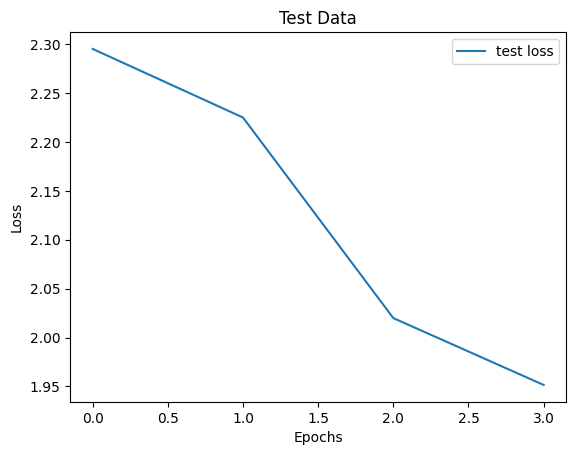

In [32]:
plt.plot(global_history["loss"], label="test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Data")
plt.legend()
plt.show()

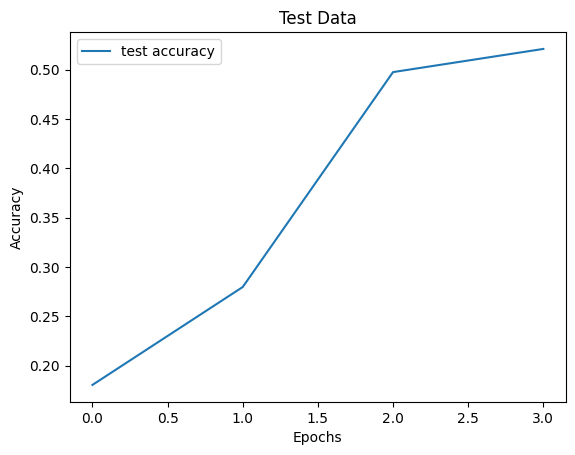

In [33]:
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()

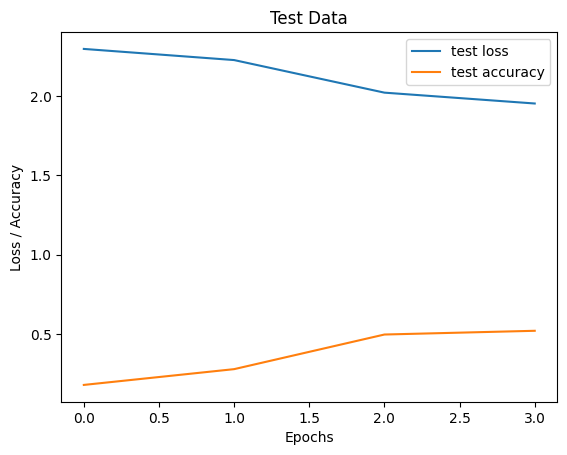

In [34]:
plt.plot(global_history["loss"], label="test loss")
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()